<a href="https://www.kaggle.com/code/hemanthkj/cora-clustering?scriptVersionId=122823385" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://colab.research.google.com/github/hemanthkumar17/Graph_Machine_Learning/blob/main/Graph_Clustering_CORA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
import numpy as np
import scipy
from scipy import linalg
import matplotlib.pyplot as plt
import random

## Problem: Initialize r nodes as training set and apply label propagation to predict the labels of the unlabelled nodes

In [2]:
r = 4

### Label propagation with randomly initialized nodes

In [3]:
G = nx.karate_club_graph()
labels = {}

random.seed(4)

one_hot = {"Mr. Hi": -1, "Officer": 1}
# node1 = []
# node2 = []
# for v in G.nodes():
#     if G.nodes[v]["club"] == "Mr. Hi":
#         node1.append(v)
#     else:
#         node2.append(v)

nodes = []
# nodes += random.sample(node1, k=r//2)
# nodes += random.sample(node2, k=r - r//2)
nodes = random.sample(G.nodes(), k=r)
for node in nodes:
    labels[node] = one_hot[G.nodes[node]["club"]]

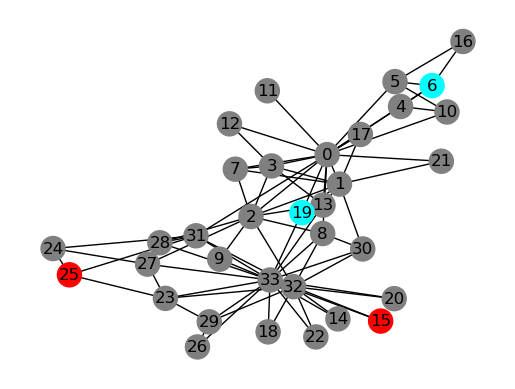

In [4]:
colors = []

for v in G.nodes():
    if v in labels:
        if labels[v] == 1:
            colors.append('red')
        else:
            colors.append('cyan')
    else:
        colors.append('gray')

pos = nx.spring_layout(G)
        
nx.draw_networkx_nodes(G, pos=pos, node_color=colors)
lb = nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos)
plt.box(False)
plt.savefig('label-prop-input.png', dpi=150, bbox_inches='tight')

In [5]:
from sklearn.linear_model import LinearRegression

def laplacian_regularization(G, labels, k=2):
    L = nx.laplacian_matrix(G)
    eigvals, eigvecs = linalg.eigh(L.todense(), subset_by_index=(0,k-1))
    
    y = np.zeros(G.number_of_nodes())

    i = 0
    for v in G.nodes():
        if v in labels:
            y[i] = labels[v]
        i = i + 1
    
    reg = LinearRegression(fit_intercept=False).fit(eigvecs, y)
        
    y = reg.predict(eigvecs)
        
    y[y >= 0] = 1
    y[y < 0] = -1
        
    pred = {}
    
    i = 0
    for v in G.nodes():
        pred[v] = int(y[i])
        i = i + 1
        
    return pred

In [6]:
def label_propagation(G, labels, n_iter=200):
    y = np.zeros((G.number_of_nodes(),1))
    idx = []

    i = 0
    for v in G.nodes():
        if v in labels:
            y[i,0] = labels[v]
            idx.append(i)
        i = i + 1
        
    y0 = y.copy()    
    P = nx.google_matrix(G, alpha=1.)
    
    idx = np.array(idx, dtype=int)
        
    for i in range(n_iter):
        y = P @ y
        y[idx,:] = y0[idx]
        
    y[y >= 0] = 1
    y[y < 0] = -1
        
    pred = {}
    
    i = 0
    for v in G.nodes():
        pred[v] = int(y[i])
        i = i + 1
    
    return pred

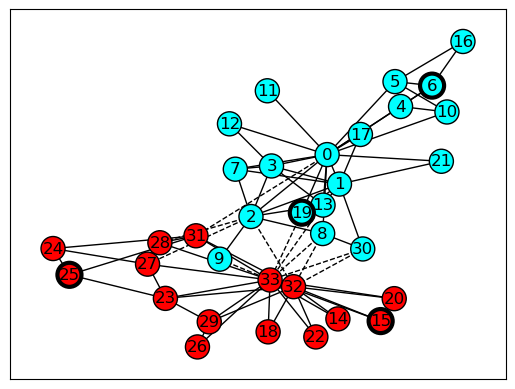

In [7]:
pred = label_propagation(G, labels)

colors = []
widths = []

for v in G.nodes():
    if pred[v] == 1:
        colors.append('red')
    else:
        colors.append('cyan')
        
    if v in labels:
        widths.append(3.)
    else:
        widths.append(1.)

cut_edges = []
non_cut_edges = []

for e in G.edges():
    u,v = e
    if pred[u] != pred[v]:
        cut_edges.append(e)
    else:
        non_cut_edges.append(e)

nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=colors, linewidths=widths)
nodes.set_edgecolor('black')
lb = nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashed')
nx.draw_networkx_edges(G, pos, edgelist=non_cut_edges, style='solid')

In [8]:
# acc = 0
# for v in G.nodes():
#     if pred[v] == one_hot[G.nodes[v]["club"]]:
#         acc += 1
# acc /= len(G.nodes) / 100
# print("Accuracy = " + str(acc) + "%")

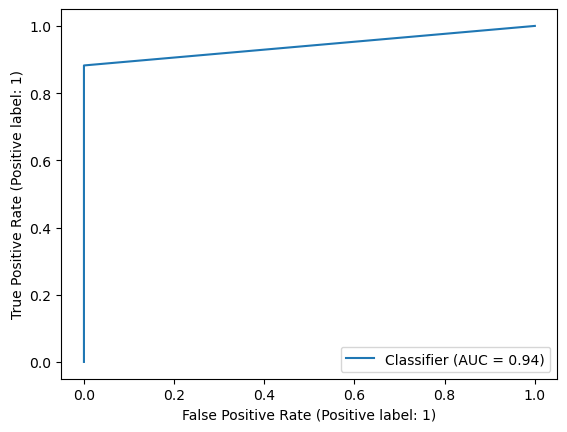

In [9]:
true = []
for v in G.nodes():
    if G.nodes[v]["club"] == 'Mr. Hi':
        true.append(one_hot["Mr. Hi"])
    else:
        true.append(one_hot["Officer"])
from sklearn import metrics
metrics.RocCurveDisplay.from_predictions(true, list(pred.values()))
fpr, tpr, thresholds = metrics.roc_curve(true, list(pred.values()))
auc1 = metrics.auc(fpr, tpr)

In [10]:
metrics.precision_recall_fscore_support(true, list(pred.values()), average='macro')

(0.9473684210526316, 0.9411764705882353, 0.9409722222222222, None)

In [11]:

from sklearn.metrics import accuracy_score
acc = accuracy_score(true, list(pred.values()))
print("Accuracy = " + str(acc) + "%")

Accuracy = 0.9411764705882353%


## Non-random initialization
### Cluster entire graph into r clusters



In [12]:
G = nx.karate_club_graph()


In [13]:
node1 = []
node2 = []
for v in G.nodes():
    if G.nodes[v]["club"] == "Mr. Hi":
        node1.append(v)
    else:
        node2.append(v)

In [14]:
G1 = G.subgraph(node1)
G2 = G.subgraph(node2)

In [15]:
from sklearn.cluster import SpectralClustering
clust = SpectralClustering(n_clusters=r//2, affinity="nearest_neighbors",random_state=8, n_init=100)
pred1 = clust.fit_predict(nx.adjacency_matrix(G1))

/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_spectral.py:590: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  "The spectral clustering API has changed. ``fit``"


In [16]:
clust = SpectralClustering(n_clusters=r - r//2, affinity="nearest_neighbors",random_state=8, n_init=100)
pred2 = clust.fit_predict(nx.adjacency_matrix(G2))

/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_spectral.py:590: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  "The spectral clustering API has changed. ``fit``"


In [17]:
from sklearn.cluster import SpectralClustering
clust = SpectralClustering(n_clusters=2, affinity="nearest_neighbors",random_state=8, n_init=100)
pred = clust.fit_predict(nx.adjacency_matrix(G))

/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_spectral.py:590: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  "The spectral clustering API has changed. ``fit``"


In [18]:
# deg = [[] for i in range(r//2)]
# for p, v in zip(pred1, G1.nodes()):
#     deg[p].append(v)
# nodes = [max(d) for d in deg]

# deg = [[] for i in range(r - r//2)]
# for p, v in zip(pred2, G2.nodes()):
#     deg[p].append(v)
# nodes += [max(d) for d in deg]

In [19]:
clusts = [[] for i in range(2)]
deg = [[] for i in range(2)]
for p, v in zip(pred, G.nodes()):
    clusts[p].append((G.degree(v), v))
nodes = [x[1] for x in sorted(clusts[0], reverse=True)[:r//2]]
nodes += [x[1] for x in sorted(clusts[1], reverse=True)[:r - r//2]]

In [20]:
nodes

[0, 2, 33, 32]

In [21]:

labels = {}
one_hot = {"Mr. Hi": -1, "Officer": 1}
for node in nodes:
    labels[node] = one_hot[G.nodes[node]["club"]]

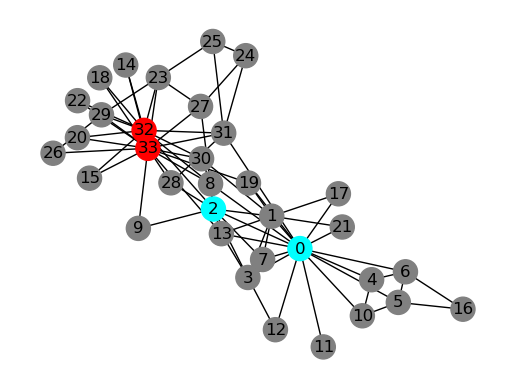

In [22]:
colors = []

for v in G.nodes():
    if v in labels:
        if labels[v] == 1:
            colors.append('red')
        else:
            colors.append('cyan')
    else:
        colors.append('gray')

pos = nx.spring_layout(G)
        
nx.draw_networkx_nodes(G, pos=pos, node_color=colors)
lb = nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos)
plt.box(False)
plt.savefig('label-prop-input.png', dpi=150, bbox_inches='tight')

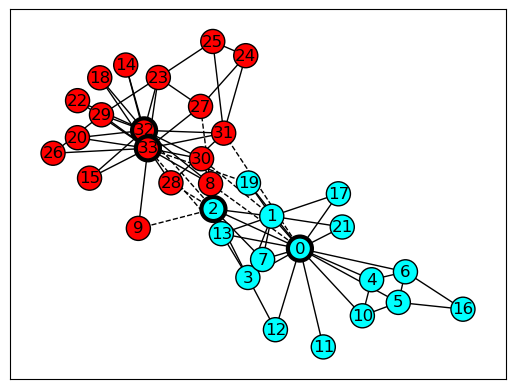

In [23]:
pred = label_propagation(G, labels)

colors = []
widths = []

for v in G.nodes():
    if pred[v] == 1:
        colors.append('red')
    else:
        colors.append('cyan')
        
    if v in labels:
        widths.append(3.)
    else:
        widths.append(1.)

cut_edges = []
non_cut_edges = []

for e in G.edges():
    u,v = e
    if pred[u] != pred[v]:
        cut_edges.append(e)
    else:
        non_cut_edges.append(e)

nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=colors, linewidths=widths)
nodes.set_edgecolor('black')
lb = nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashed')
nx.draw_networkx_edges(G, pos, edgelist=non_cut_edges, style='solid')

In [24]:
acc = 0
for v in G.nodes():
    if pred[v] == one_hot[G.nodes[v]["club"]]:
        acc += 1
acc /= len(G.nodes) / 100
print("Accuracy = " + str(acc) + "%")

Accuracy = 97.05882352941175%


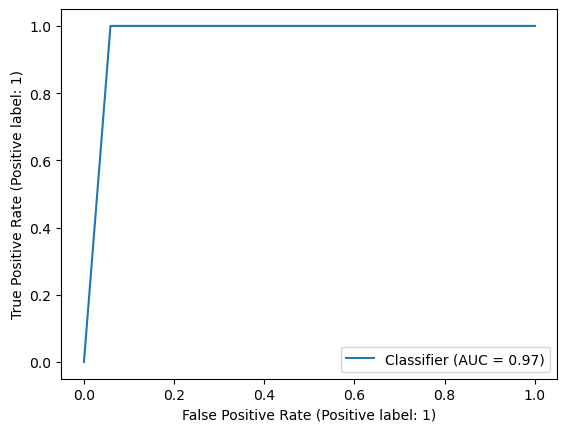

In [25]:
true = []
for v in G.nodes():
    if G.nodes[v]["club"] == 'Mr. Hi':
        true.append(one_hot["Mr. Hi"])
    else:
        true.append(one_hot["Officer"])
from sklearn import metrics
metrics.RocCurveDisplay.from_predictions(true, list(pred.values()))
fpr, tpr, thresholds = metrics.roc_curve(true, list(pred.values()))
auc1 = metrics.auc(fpr, tpr)

In [26]:
metrics.precision_recall_fscore_support(true, list(pred.values()), average='macro')

(0.9722222222222222, 0.9705882352941176, 0.9705627705627706, None)

# Q4 CORA Clustering

In [27]:
# !pip install -q datasets

In [28]:
# from datasets import load_dataset

# dataset = load_dataset("gcaillaut/cora")

In [29]:
import networkx as nx

In [30]:
# G = nx.Graph()
# G.add_nodes_from(dataset['train']['node'])
# G.add_edges_from(dataset['train']['neighbors'])

In [31]:
!pip install torch_geometric torch_sparse torch_scatter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for torch_geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=1927176e602eb46bbcd72bdd8f32411d6c5c671a704da064e4112b725e77ff55
  Stored in directory: /root/.cache/pip/wheels/83/b2/dc/5a92df31573f946e8f3ca62b861be8a6a55c5228ed27cc989b
  Created wheel for torch_sparse: filename=torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl size=1080200 sha256=703d975abfc9e31f04c72b79f4ef978b7816565a54e33810ca16c2cd3e6b5066
  Stored in directory: /root/.cache/pip/wheels/ff/5c/28/5d12cf8ac7bb8bc3de9dda8fa446cb4aeb9fffe19ef1028538
  Created wheel for torch_scatter: filename=torch_scatter-2.1.1

In [32]:
from torch_geometric.datasets import Planetoid
import networkx as nx
from torch_geometric.utils import to_networkx
from sklearn.metrics.cluster import adjusted_rand_score

dataset = Planetoid(root='~/somewhere/Cora', name='Cora')
data = dataset[0]
G = to_networkx(data, to_undirected=True)

Processing...
Done!


In [33]:
G = to_networkx(data, to_undirected=True)
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
largest_cc = G.subgraph(Gcc[0])
a = nx.adjacency_matrix(largest_cc)

In [34]:
len(data.x[list(largest_cc.nodes())])

2485

In [35]:
import torch
lab = dataset[0].x
torch.where(lab==1)[1]

tensor([  19,   81,  146,  ..., 1328, 1412, 1414])

In [36]:
from sklearn.cluster import SpectralClustering
clust = SpectralClustering(n_clusters=7,assign_labels='kmeans', affinity="nearest_neighbors", random_state=0)
pred = clust.fit_predict(data.x[list(largest_cc.nodes())])
print(pred)
adjusted_rand_score(dataset[0].y[list(largest_cc.nodes())], pred)

[2 4 0 ... 3 2 2]


0.0977752968196539

In [37]:
from sklearn.cluster import SpectralClustering
clust = SpectralClustering(n_clusters=7,assign_labels='kmeans', affinity="precomputed", random_state=0)
pred = clust.fit_predict(a)
print(pred)
adjusted_rand_score(dataset[0].y[list(largest_cc.nodes())], pred)

[0 0 0 ... 0 0 0]


-0.013354426626133611

In [38]:
from sklearn.metrics import rand_score
rand_score(dataset[0].y[list(largest_cc.nodes())], pred)

0.3032520404228916

### Varied cluster size for node-based

In [39]:
from sklearn.cluster import SpectralClustering
clust = SpectralClustering(n_clusters=10,assign_labels='kmeans', affinity="nearest_neighbors", random_state=0)
pred = clust.fit_predict(data.x[list(largest_cc.nodes())])
print(pred)
adjusted_rand_score(dataset[0].y[list(largest_cc.nodes())], pred)

[0 5 1 ... 8 0 0]


0.10243208198005992

In [40]:
from sklearn.cluster import SpectralClustering
clust = SpectralClustering(n_clusters=5,assign_labels='kmeans', affinity="nearest_neighbors", random_state=0)
pred = clust.fit_predict(data.x[list(largest_cc.nodes())])
print(pred)
adjusted_rand_score(dataset[0].y[list(largest_cc.nodes())], pred)

[1 2 0 ... 4 1 1]


0.10736982499488744

### Varied cluster size for adjacency matrix

In [41]:
from sklearn.cluster import SpectralClustering
clust = SpectralClustering(n_clusters=10,assign_labels='kmeans', affinity="precomputed", random_state=0)
pred = clust.fit_predict(a)
print(pred)
adjusted_rand_score(dataset[0].y[list(largest_cc.nodes())], pred)

[1 1 1 ... 1 1 1]


0.17551980888044477

In [42]:
from sklearn.cluster import SpectralClustering
clust = SpectralClustering(n_clusters=5,assign_labels='kmeans', affinity="precomputed", random_state=0)
pred = clust.fit_predict(a)
print(pred)
adjusted_rand_score(dataset[0].y[list(largest_cc.nodes())], pred)

[0 0 0 ... 0 0 0]


-0.010739496928633458

In [43]:
# b = nx.adjacency_matrix(largest_cc)
# for i in range(len(largest_cc.nodes())):
#     print(torch.where(data.x[list(largest_cc.nodes())[i]] == 1))
#     b[i,i] = data.x[list(largest_cc.nodes())[i]]